<a href="https://colab.research.google.com/github/haidaraf6/MLCAPSTONE/blob/main/MODEL_TOMATO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import zipfile
import tensorflow_datasets as tfds


# Prepare the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab/dataset.zip'

In [ ]:
!unrar x -Y "/content/drive/MyDrive/Colab/Rice Dataset.rar" "/content/dataset/"

In [ ]:
import zipfile

file_dataset = '/content/drive/MyDrive/ModelML /Tomato/dataset_tomato.zip'
zipdata = zipfile.ZipFile(file_dataset, 'r')
zipdata.extractall('dataset')
zipdata.close()


# Model Build

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, PReLU, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(LSTM(50, return_sequence=False))
model.add(Dense(11, activation='softmax'))

model.summary()


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
*The settings can be changed later*


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/dataset/dataset_tomato/Train'
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = '/content/dataset/dataset_tomato/Val'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32
)


Found 25847 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [ ]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

In [ ]:
model_h5 = '/content/drive/MyDrive/Colab/Model/my_model_rice_new.h5'
model=tf.keras.models.load_model(model_h5)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint("model.h5",
                           monitor='val_accuracy',
                           verbose=1,
                           save_base_only=True,
                           mode='max')


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      if logs['val_accuracy'] > 0.90:
        if logs['val_loss'] < 0.25:
          self.model.stop_training = True

myCallback = myCallback()

# Train the Model

In [ ]:
history = model.fit(train_generator, epochs=60, validation_data=validation_generator, callbacks=[myCallback, checkpoint])

Epoch 1/60
808/808 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8242
Epoch 1: saving model to model.h5
808/808 [==============================] - 360s 441ms/step - loss: 0.5101 - accuracy: 0.8242 - val_loss: 0.4290 - val_accuracy: 0.8532
Epoch 2/60
808/808 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8296
Epoch 2: saving model to model.h5
808/808 [==============================] - 342s 423ms/step - loss: 0.4991 - accuracy: 0.8296 - val_loss: 0.6265 - val_accuracy: 0.8083
Epoch 3/60
808/808 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8327
Epoch 3: saving model to model.h5
808/808 [==============================] - 346s 429ms/step - loss: 0.4947 - accuracy: 0.8327 - val_loss: 0.4479 - val_accuracy: 0.8510
Epoch 4/60
808/808 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8293
Epoch 4: saving model to model.h5
808/808 [==============================] - 349s 431ms/step - loss: 0.4900 -

Tes Akurasi dan Loss

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

209/209 [==============================] - 27s 128ms/step - loss: 0.3874 - accuracy: 0.8670
Test Loss: 0.3873973488807678
Test Accuracy: 0.8669759035110474


Run code below to show accuracy plot

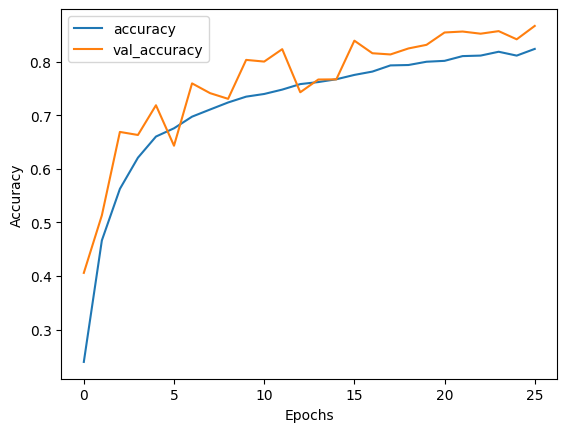

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(26), history.history['accuracy'])
plt.plot(np.arange(26), history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# Predict image using the model

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

class_names = [
    "Tomato_Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato_healty",
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_mosaic_virus",
    "Tomato_powdery_mildew",
    "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two-spotted_spider_mite",
    "Tomato_Target_Spot",
    "Tomato_Yellow_Leaf_Curl_Virus"
]

for fn in uploaded.keys():
    # Memprediksi gambar
    path = fn
    img = load_img(path, target_size=(200, 200))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=100)

    predicted_class_index = np.argmax(classes, axis=1)[0]
    predicted_class = class_names[predicted_class_index]

    if predicted_class_index < 5:
        print("Chili:", predicted_class)
    elif predicted_class_index < 11:
        print("Rice:", predicted_class)
    elif predicted_class_index < 21:
        print("Tomato:", predicted_class)

    print(classes)
    print(fn)
    print("Hasil klasifikasi:", predicted_class)


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/content/rice3-1.jpg', target_size=(200, 200))
img = np.expand_dims(img, axis=0)
#images = np.vstack([img])
model.predict(img)

# Save the Trained Model

In [ ]:
from google.colab import files

saved_model_path = "./model_tomato.h5"
model.save(saved_model_path)
files.download(saved_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp '/content/my_model_rice90.h5' '/content/drive/MyDrive/Colab/Model'

In [ ]:
!cp '/content/model_rice_new.json' '/content/drive/MyDrive/Colab/Model'

Save Model to Json

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files

# Load the saved model
saved_model_path = "./model_tomato.h5"
model = load_model(saved_model_path)

# Convert the model to JSON format
json_model = model.to_json()

# Save the JSON model to a file
json_model_path = "./model_tomato.json"
with open(json_model_path, "w") as json_file:
    json_file.write(json_model)

# Download the JSON model file
files.download(json_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save to TensorFlow Lite

In [ ]:
model=tf.keras.models.load_model("model.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files


saved_model_path = "./model_tomato.h5"
model = load_model(saved_model_path)


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


tflite_model_path = "./model_tomato.tflite"
with open(tflite_model_path, "wb") as tflite_file:
    tflite_file.write(tflite_model)

files.download(tflite_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open ("model.tflite","wb") as tflite_file:
     tflite_file.write(converter)

In [ ]:
import os
from PIL import Image

folder_path = '/content/dataset/DATASET/Val'

def check_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifikasi gambar
            except (IOError, SyntaxError) as e:
                print("File rusak:", file_path)

check_images(folder_path)
